# Loading Libraries

In [61]:
import numpy as np
import pandas as pd
import sklearn
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
# from load_data import *
# import rpy2
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import statsmodels.api as sm
import itertools
from scipy import stats

In [2]:
# !pip install plotly==2.7.0
import pandas as pd
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.plotly as py
import matplotlib.pyplot as plt
from matplotlib import pyplot
import plotly.graph_objs as go

# Load Data

In [3]:
import glob
path = "Yahoo_S5_Data\\A1Benchmark"
all_files=glob.glob(path+"/*.csv")

dataset_conc=[]
for filename in all_files:
    df=pd.read_csv(filename,index_col=None,header=0)
#     df=df.dropna(axis=0, how='any',subset=['value'])
    file_name= filename.split('\\')[-1][:-4]
    text, number = file_name.split('_')
    number = '0'+number if len(number)==1 else number
    df['file_name_org'] = file_name
    df['file_name'] = '_'.join([text, number ])
    df['value_normalized'] = preprocessing.normalize([df.value]).T
    dataset_conc.append(df) 
df=pd.concat(dataset_conc,axis=0,ignore_index=True)
filenames = list(set(df.file_name.tolist()))
filenames.sort()
# filenames = np.array(list(filenames)).sort()

# Visualization

## For Individual

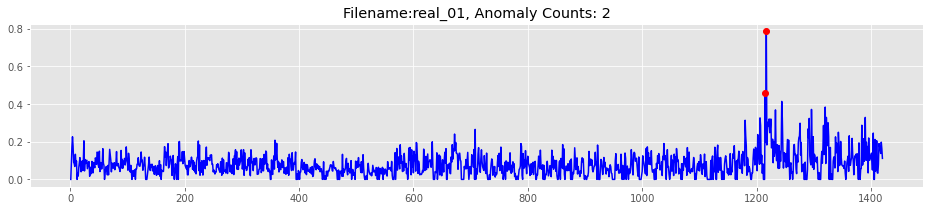

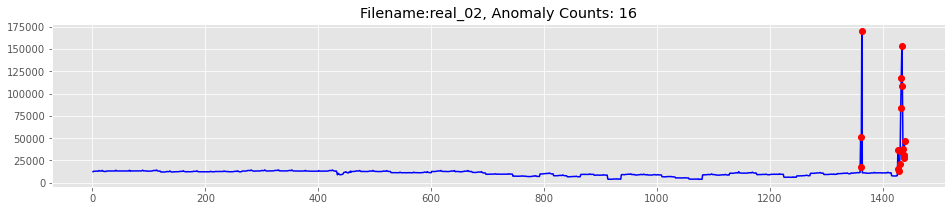

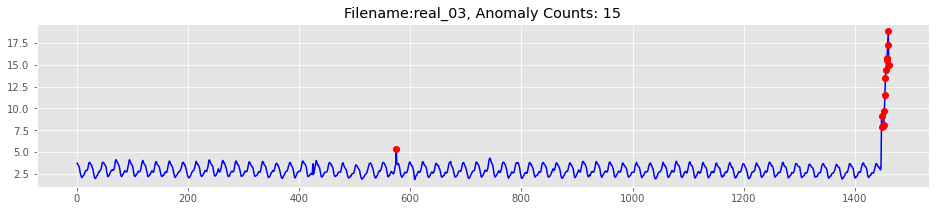

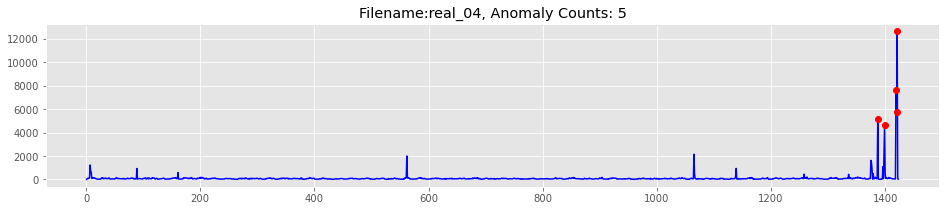

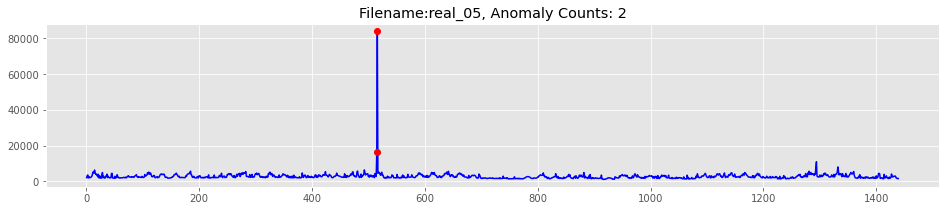

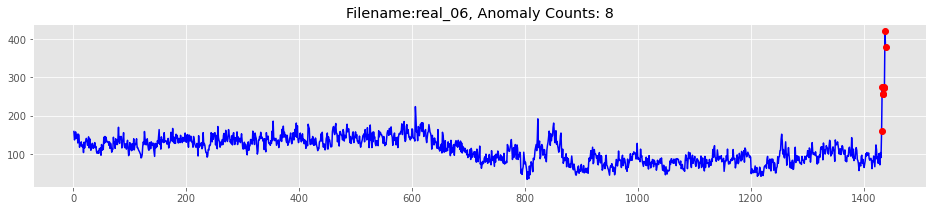

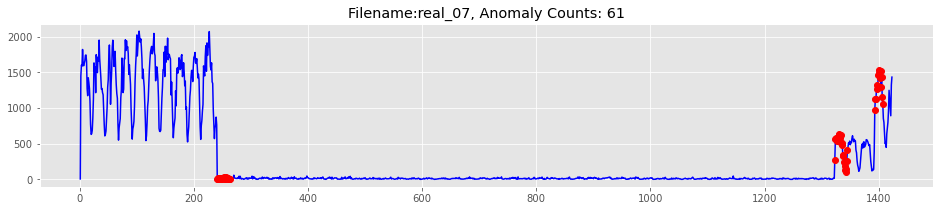

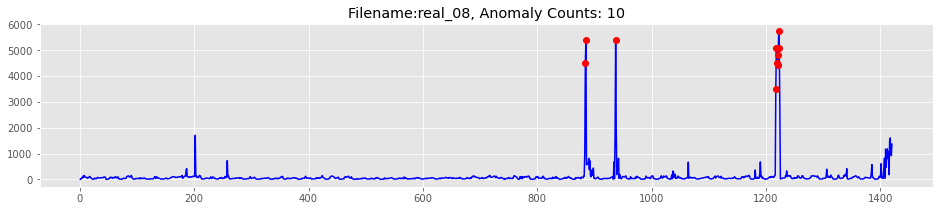

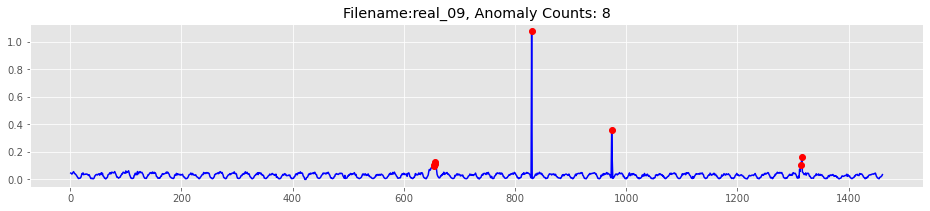

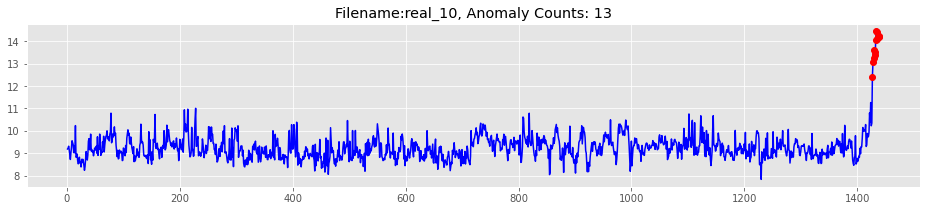

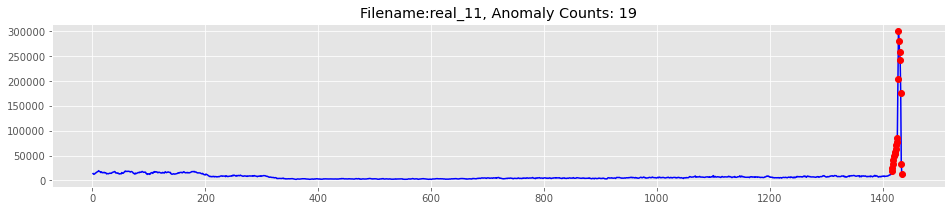

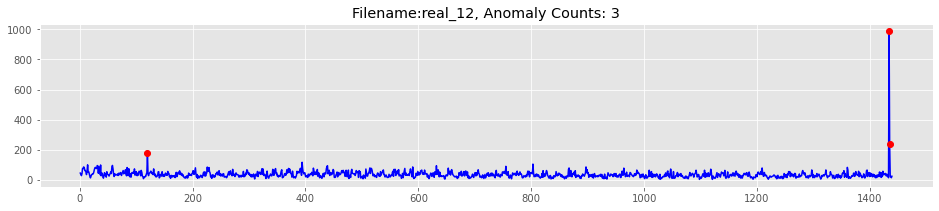

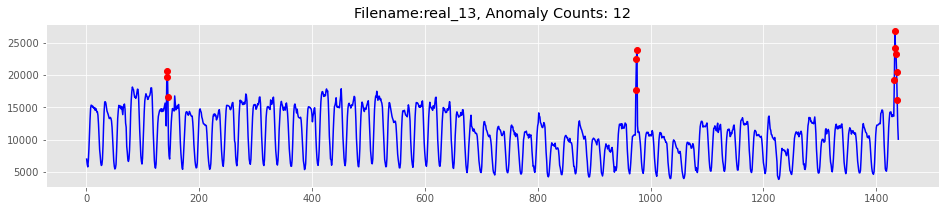

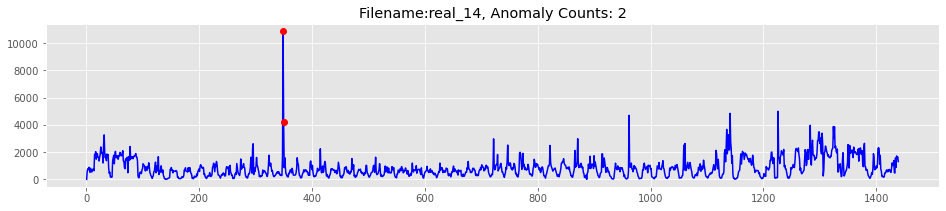

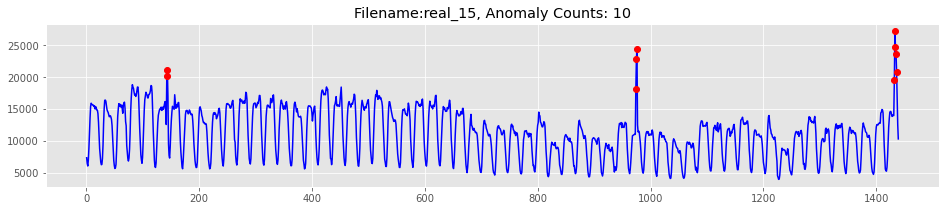

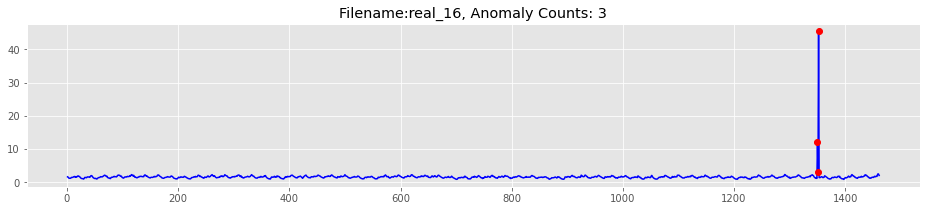

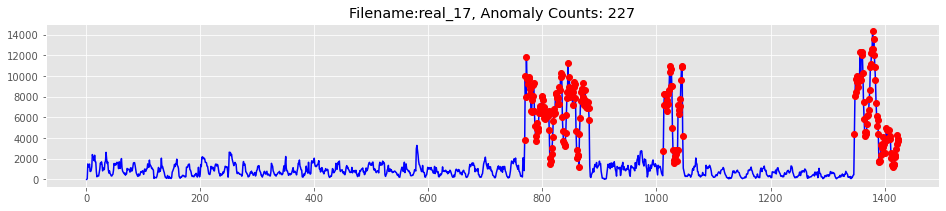

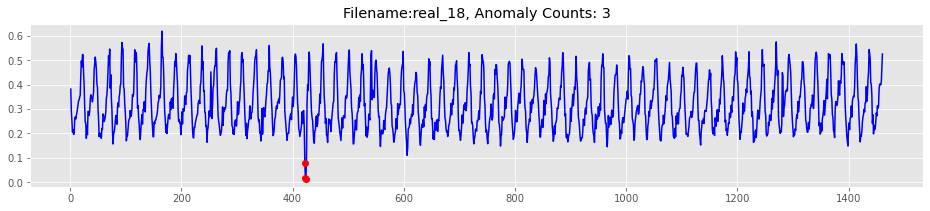

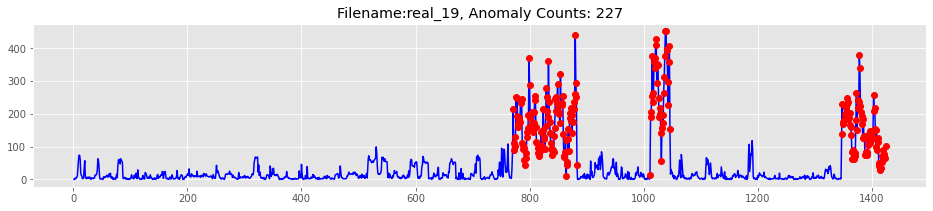

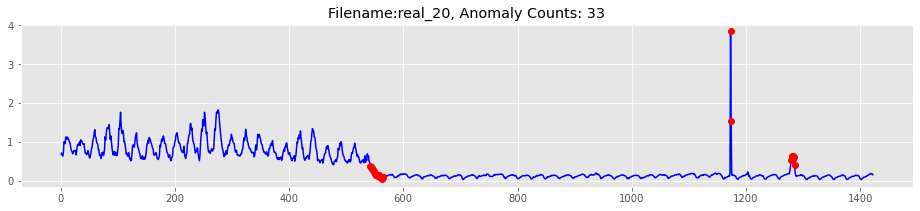

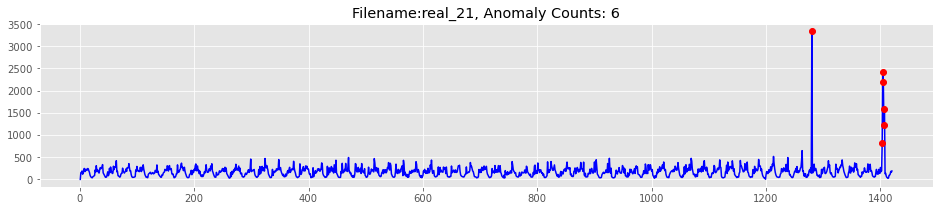

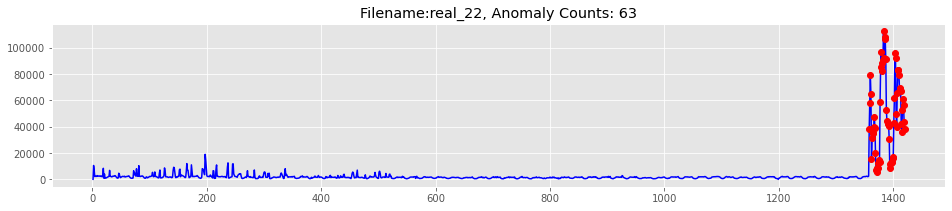

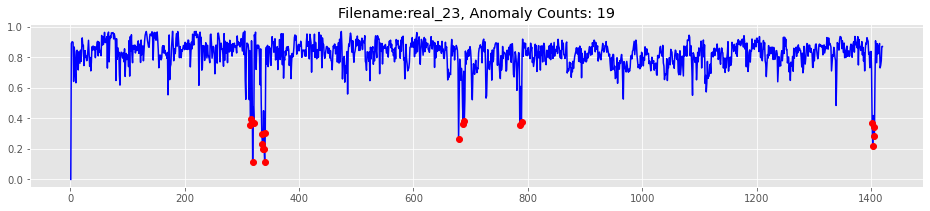

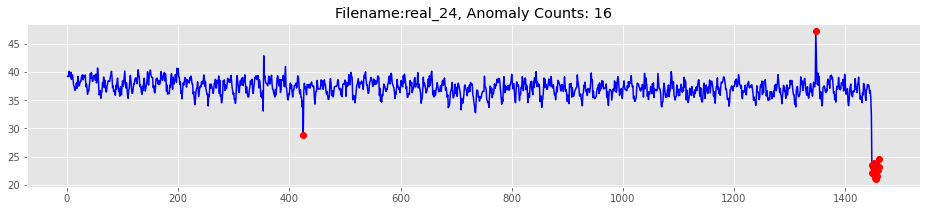

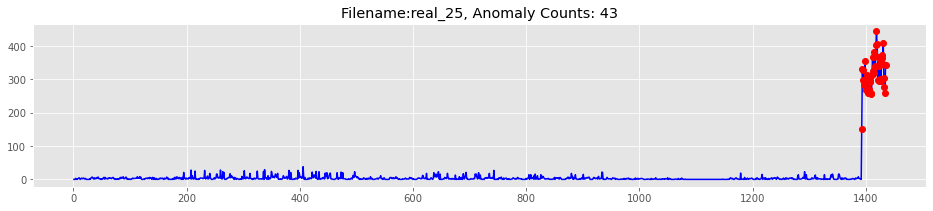

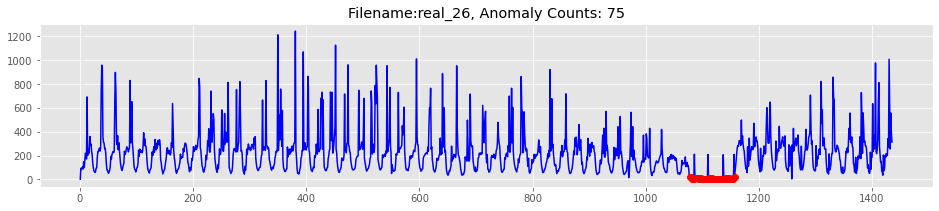

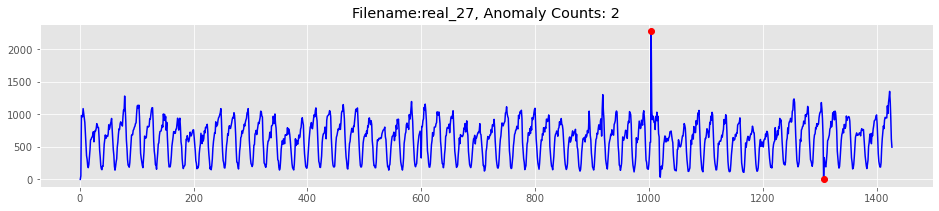

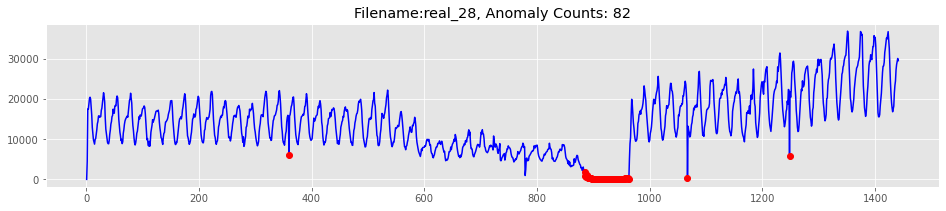

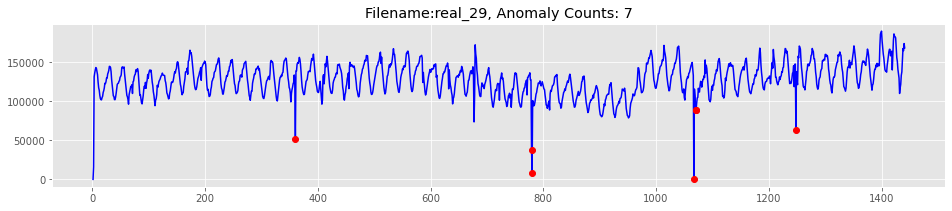

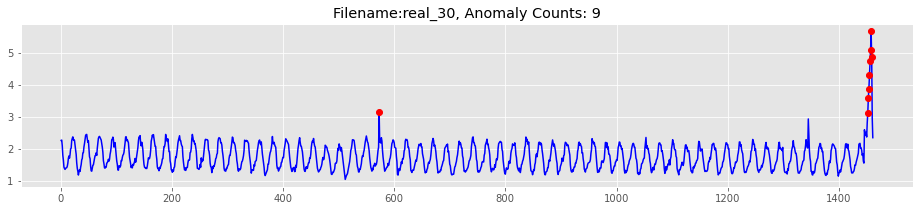

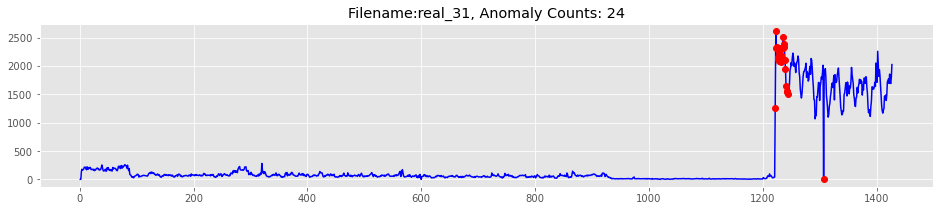

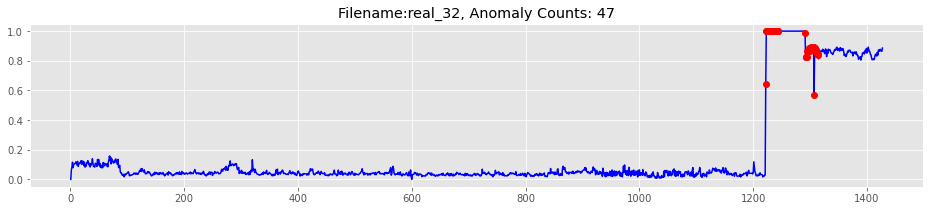

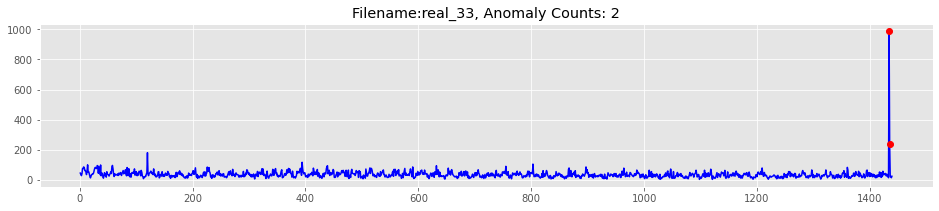

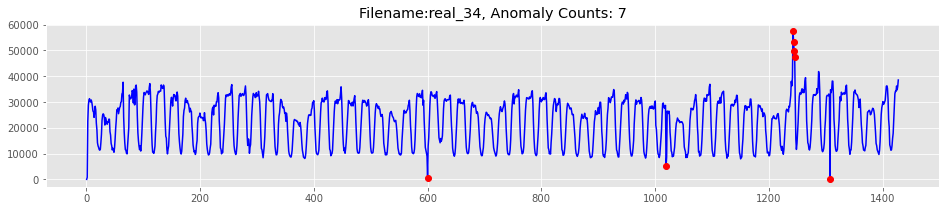

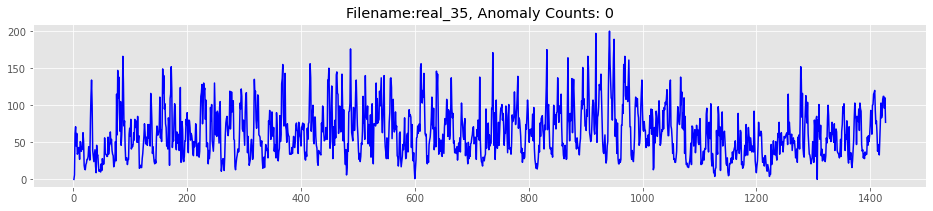

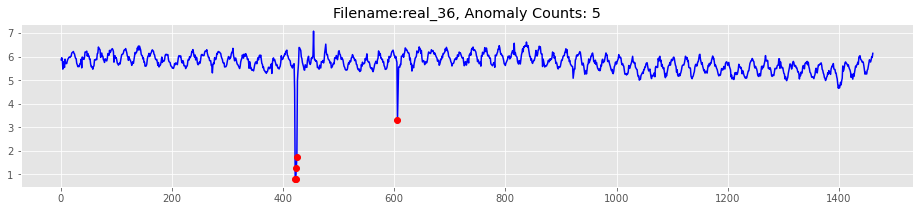

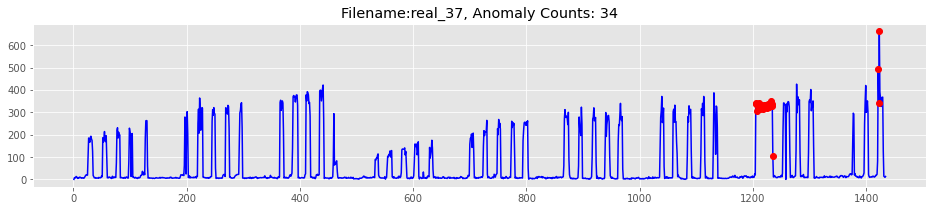

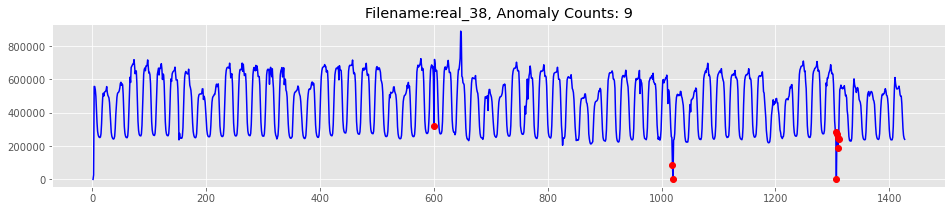

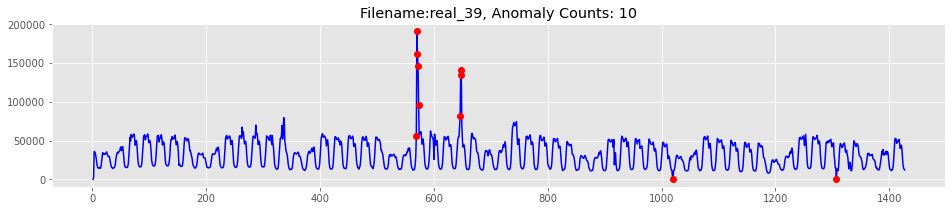

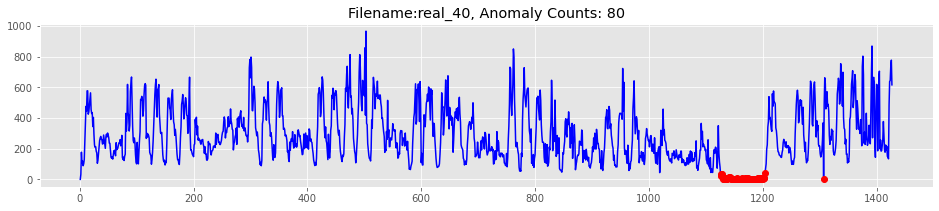

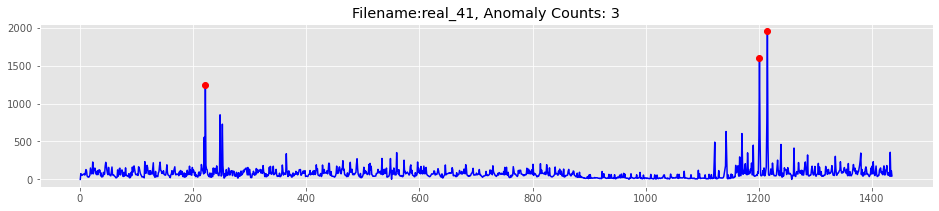

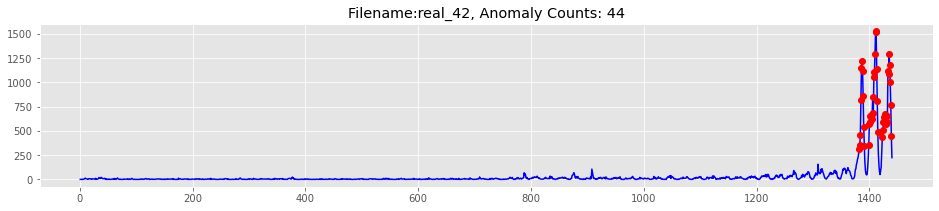

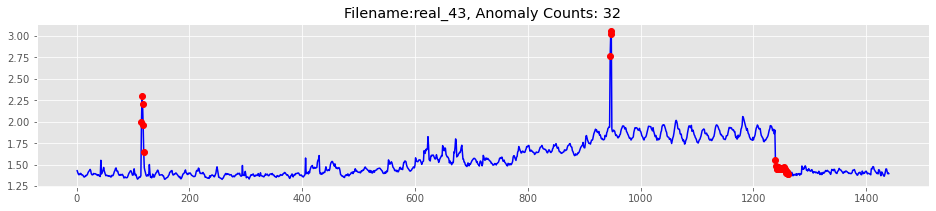

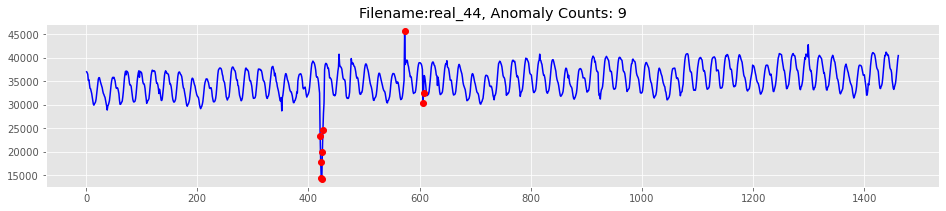

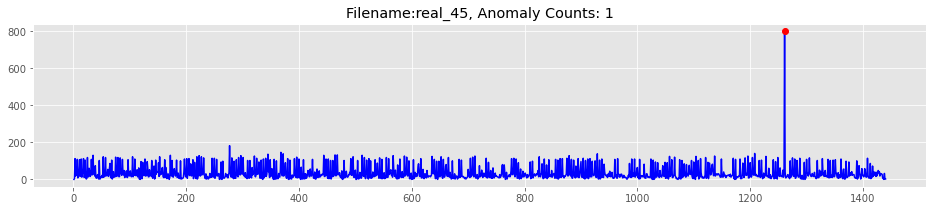

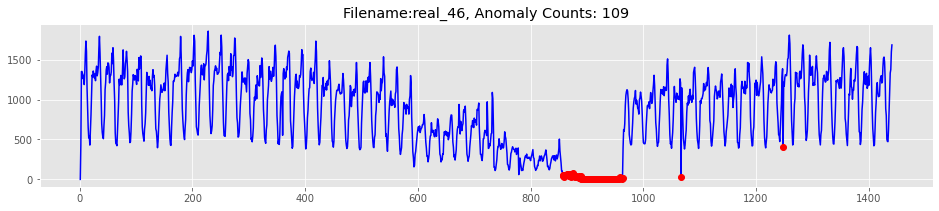

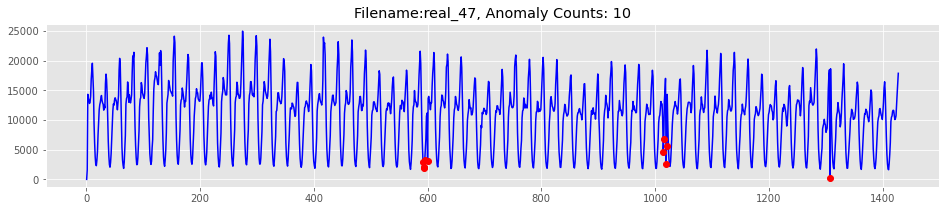

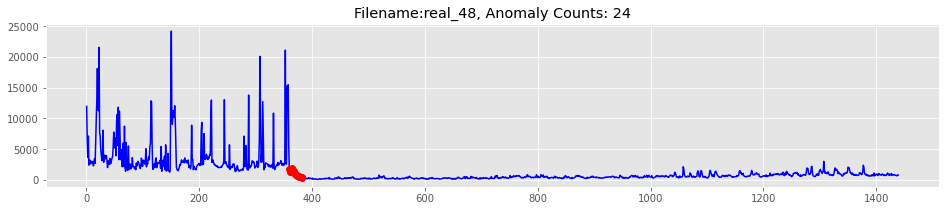

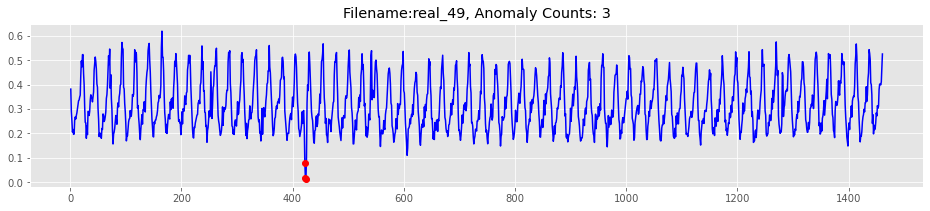

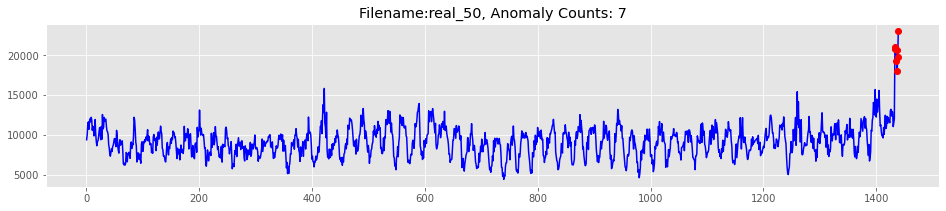

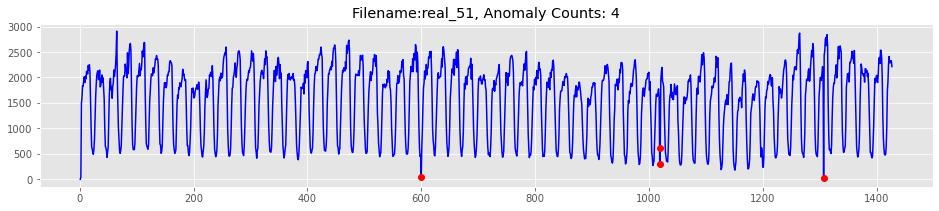

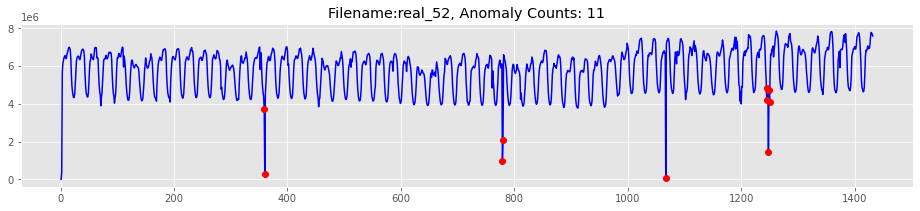

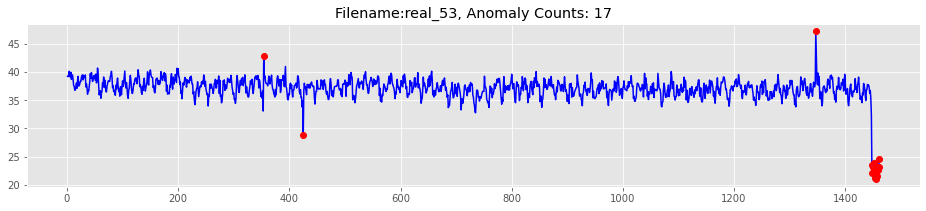

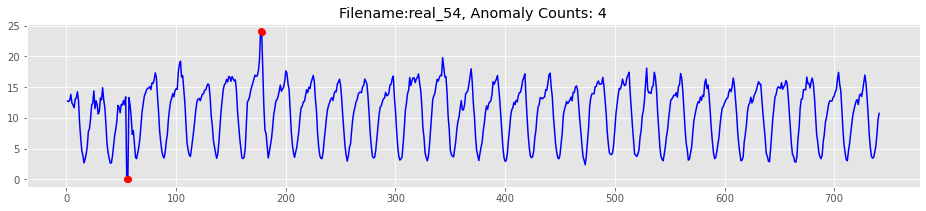

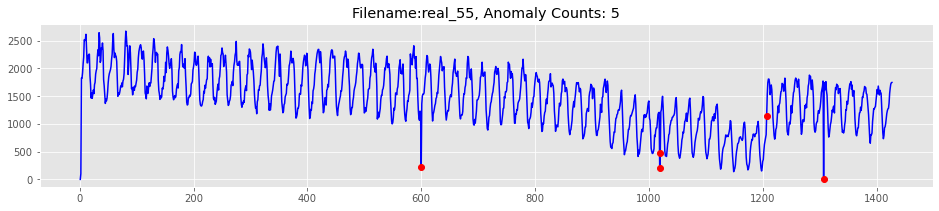

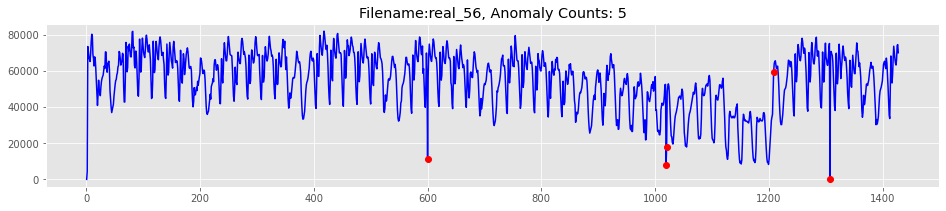

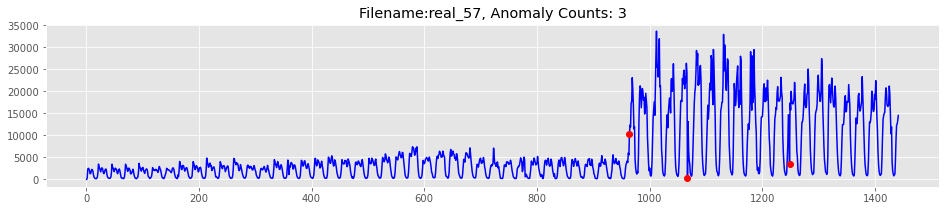

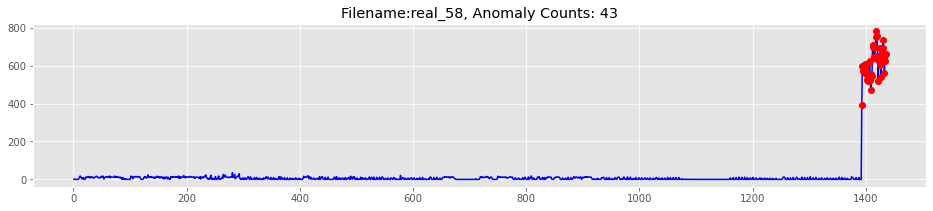

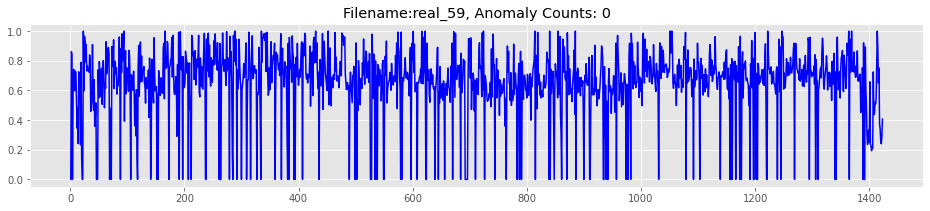

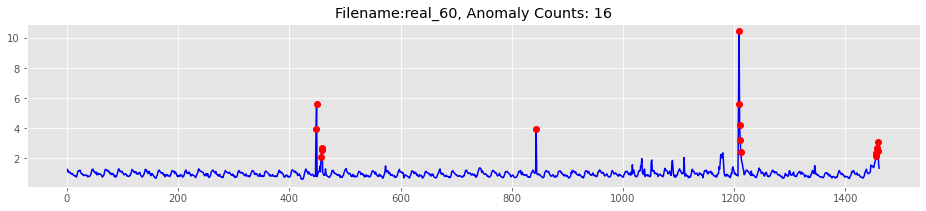

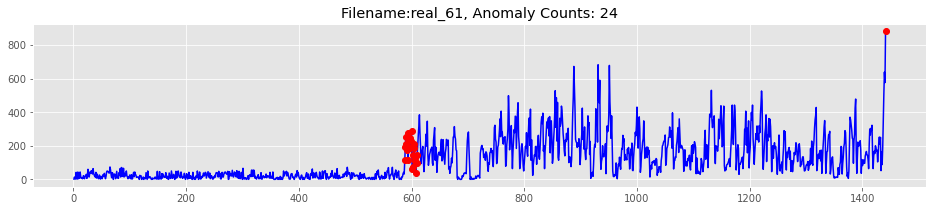

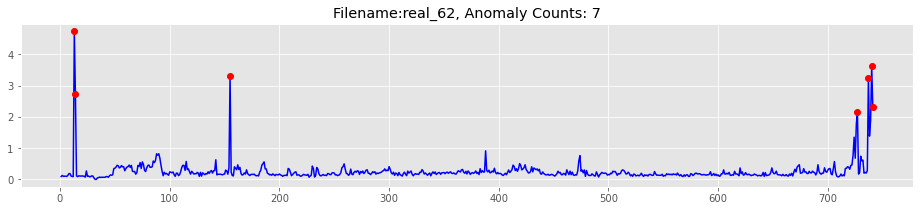

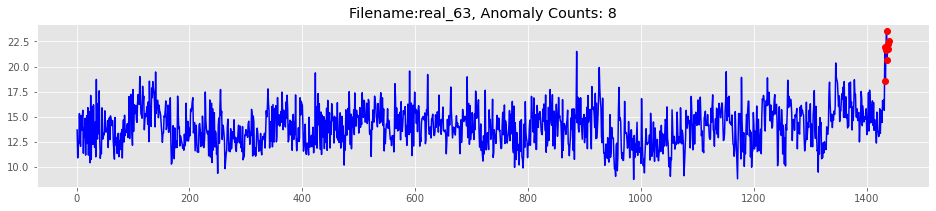

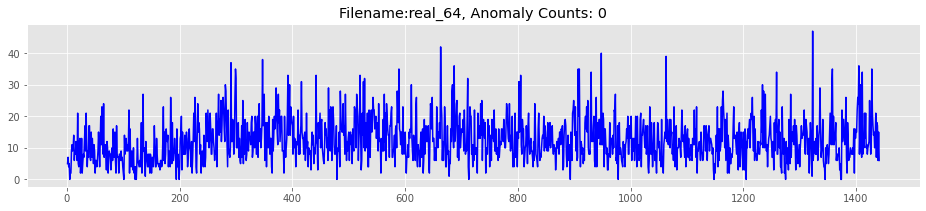

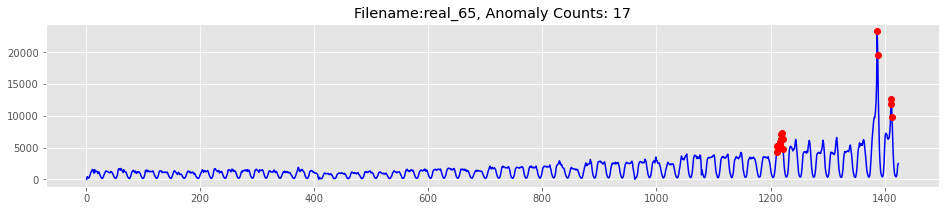

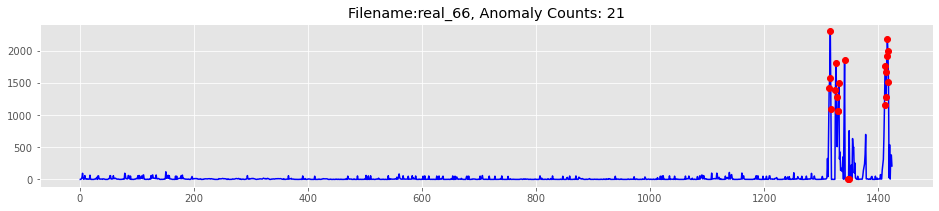

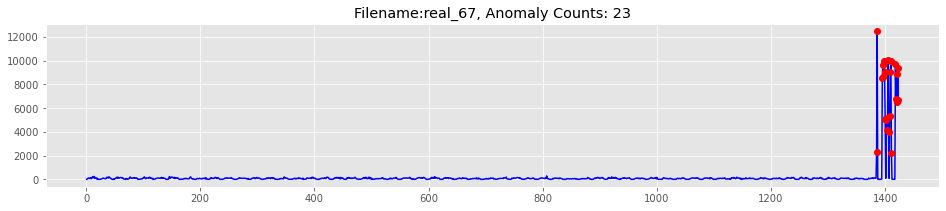

In [4]:
for filename in filenames:
    data = df[df['file_name'] == filename].copy()
    data_anomaly_positions = data.loc[data['is_anomaly'] == 1,  ('timestamp','value')]
    fig, ax = plt.subplots(1,1, figsize = (16,3))
    plt.plot(data['timestamp'], data['value'], color="blue")
    plt.title('Filename:' + filename + ', Anomaly Counts: ' + str(len(data_anomaly_positions)))
    plt.plot(data_anomaly_positions['timestamp'], data_anomaly_positions['value'], 'ro', color="red")
    plt.show()

In [5]:
selected_filenames_context = ['real_38', 'real_51']

In [6]:
selected_filenames_collective = ['real_26', 'real_40']

In [7]:
selected_filenames = ['real_37', 'real_18', 'real_20']

In [8]:
selected_filenames_work = ['real_18', 'real_39']

## For Sum

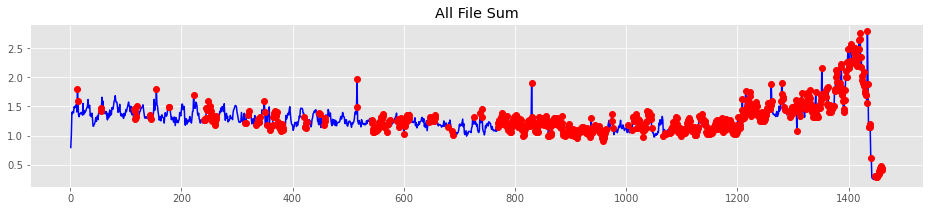

In [9]:
df_sum = df.groupby('timestamp').sum().reset_index()
df_sum_anomaly_positions = df_sum.loc[df_sum['is_anomaly'] >= 1,  ('timestamp','value_normalized')]
fig, ax = plt.subplots(1,1, figsize = (16,3))
plt.plot(df_sum['timestamp'], df_sum['value_normalized'], color="blue")
plt.title('All File Sum')
plt.plot(df_sum_anomaly_positions['timestamp'], df_sum_anomaly_positions['value_normalized'], 'ro', color="red")
plt.show()

# Models

In [469]:
# data = df[df['file_name'] == selected_filenames[1]].copy()
filename = 'real_26' #'real_38'
data = df[df['file_name'] == filename].copy()

## ARIMA

### Decompose / De-seasonality

In [470]:
y = data.reset_index(drop = True)
# value = 'value_normalized'
value = 'value'

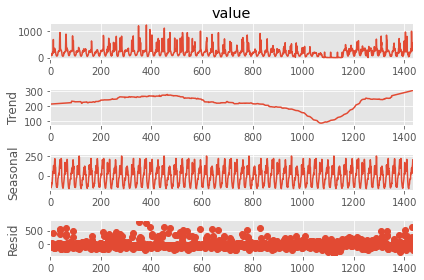

In [471]:
decomposition = sm.tsa.seasonal_decompose(y[value], model='additive', period=24*7, extrapolate_trend='freq')
# decomposition = sm.tsa.seasonal_decompose(y[value], model='multiplicative', period=24, extrapolate_trend='freq')
fig = decomposition.plot()
plt.show()

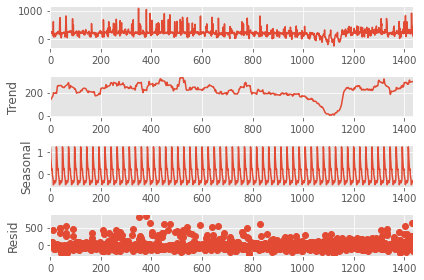

In [472]:
decomposition = sm.tsa.seasonal_decompose(decomposition.resid + decomposition.trend, 
                                          model='additive', period=24, extrapolate_trend='freq')
fig = decomposition.plot()
plt.show()

In [473]:
y['resid'] = decomposition.resid
y['de-season'] = decomposition.resid + decomposition.trend 
value = 'de-season'

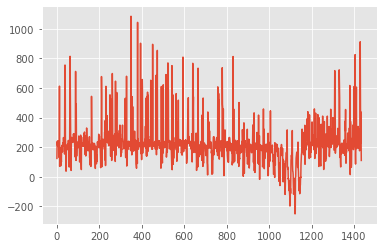

In [474]:
plt.plot(y[value])

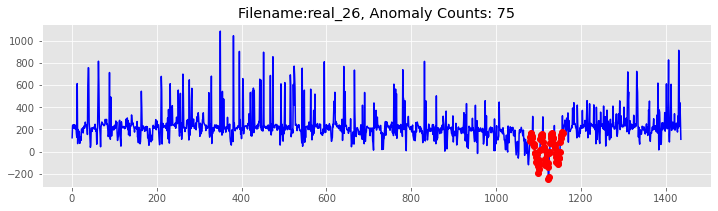

In [475]:
data = y
data_anomaly_positions = data.loc[data['is_anomaly'] == 1,  ('timestamp',value)]
fig, ax = plt.subplots(1,1, figsize = (12,3))
plt.plot(data['timestamp'], data[value], color="blue")
plt.title('Filename:' + filename + ', Anomaly Counts: ' + str(len(data_anomaly_positions)))
plt.plot(data_anomaly_positions['timestamp'], data_anomaly_positions[value], 'ro', color="red")
plt.show()

### ARIMA

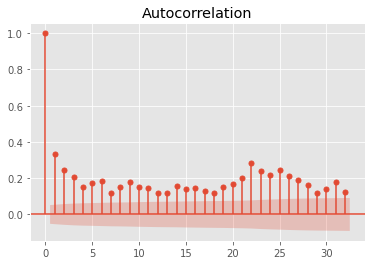

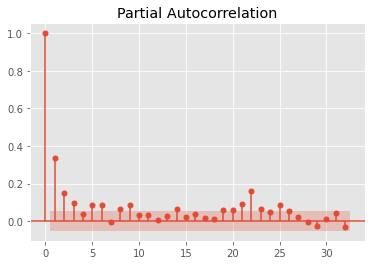

In [476]:
# Get p based on 
nlags = 10
alpha = 0.05
pacfs, pacf_confs = sm.tsa.stattools.pacf(y[value], nlags = 10, alpha = 0.05)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(y[value])
plot_pacf(y[value])
plt.show()

In [477]:
# Stationary test
from statsmodels.tsa.stattools import adfuller
print('ADF', adfuller(y[value]))
# 返回值依次为：adf, pvalue p值， usedlag, nobs, critical values临界值 , icbest, regresults, resstore 

ADF (-2.744357199212757, 0.06667199267516498, 24, 1410, {'1%': -3.434996272992033, '5%': -2.863592002111143, '10%': -2.5678624767365825}, 17519.562836717825)


In [478]:
# White noise test
from statsmodels.stats.diagnostic import acorr_ljungbox
print('acorr_ljungbox',acorr_ljungbox(y[value], lags= 1, return_df = False)) #返回统计量和 p 值

acorr_ljungbox (array([160.30446095]), array([9.70795309e-37]))


In [479]:
p = [1,2]
d = [1]
q = range(5, 10)
s = [24]
pdq = list(itertools.product(p, d, q))
pdqs = list(itertools.product(p, d, q, s))

In [480]:
best_aic = -np.inf
for param in pdqs:
    mod = sm.tsa.statespace.SARIMAX(y[value], order=param[:-1], 
#                                     seasonal_order=param,
                                    enforce_stationarity=False, enforce_invertibility=False)
    results = mod.fit()
    if results.aic>best_aic:
        best_aic = results.aic
        best_results = results
        best_mod = mod
        best_param = param
    print('ARIMA{}x{} - AIC:{}'.format(param[:-1], param, results.aic))

ARIMA(1, 1, 5)x(1, 1, 5, 24) - AIC:17777.088280415788
ARIMA(1, 1, 6)x(1, 1, 6, 24) - AIC:17765.985309342585
ARIMA(1, 1, 7)x(1, 1, 7, 24) - AIC:17754.026826795052


c:\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 1, 8)x(1, 1, 8, 24) - AIC:17744.67489948142


c:\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 1, 9)x(1, 1, 9, 24) - AIC:17730.438667874023


c:\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 1, 5)x(2, 1, 5, 24) - AIC:17768.005813020107
ARIMA(2, 1, 6)x(2, 1, 6, 24) - AIC:17763.73387568521


c:\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 1, 7)x(2, 1, 7, 24) - AIC:17752.745879736656


c:\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 1, 8)x(2, 1, 8, 24) - AIC:17737.7606152425
ARIMA(2, 1, 9)x(2, 1, 9, 24) - AIC:17734.771907923576


(1, 1, 5, 24)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0596      0.787     -0.076      0.940      -1.603       1.483
ma.L1         -0.7179      0.787     -0.912      0.362      -2.261       0.825
ma.L2         -0.1381      0.611     -0.226      0.821      -1.336       1.060
ma.L3         -0.0470      0.080     -0.591      0.555      -0.203       0.109
ma.L4         -0.0698      0.044     -1.570      0.116      -0.157       0.017
ma.L5          0.0264      0.051      0.519      0.603      -0.073       0.126
sigma2      1.477e+04    251.420     58.732      0.000    1.43e+04    1.53e+04


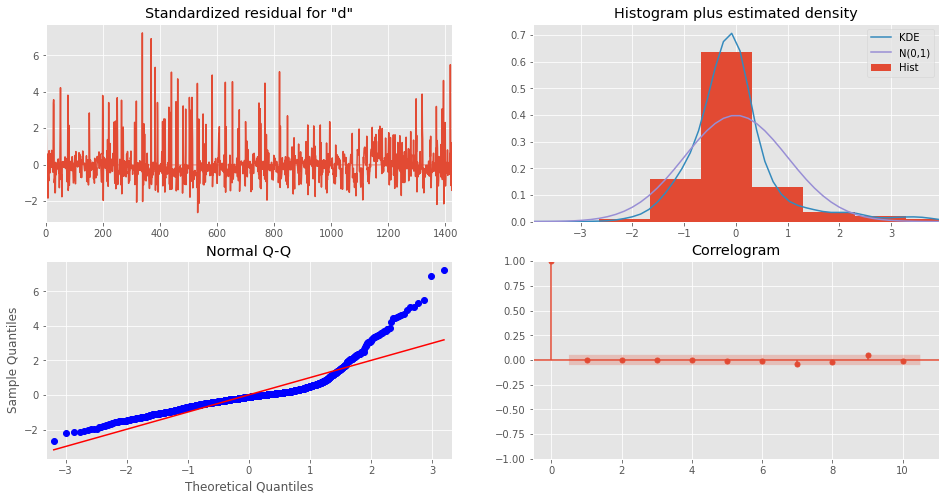

In [481]:
print(best_param)
print(best_results.summary().tables[1])
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [482]:
pred = results.get_prediction(dynamic=False)
pred_ci = pd.DataFrame(pred.conf_int())
# prediction=pred.predicted_mean.append(results.forecast(len(y) - 800))

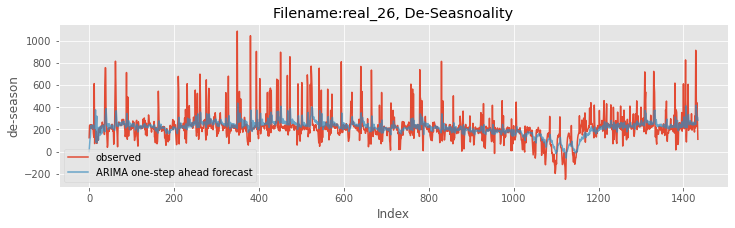

In [483]:
fig, ax = plt.subplots(1, figsize=(12, 3))
ax.plot(y[value], label='observed')
ax.plot(pred.predicted_mean, label='ARIMA one-step ahead forecast', alpha=.7)
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

y_anomaly_positions = y.loc[y['is_anomaly'] == 1][value]
# plt.plot(y_anomaly_positions, 'ro', color="red")

plt.title('Filename:' + filename + ', De-Seasnoality')

ax.set_xlabel('Index')
ax.set_ylabel(value)
plt.legend()
plt.show()

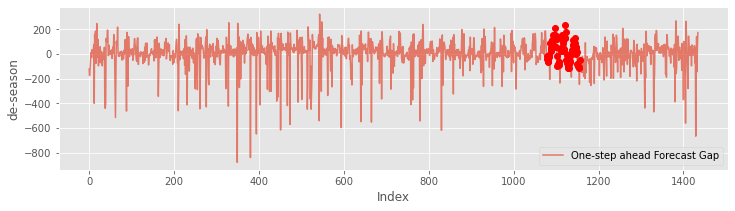

In [484]:
fig, ax = plt.subplots(1, figsize=(12, 3))
# ax.plot(y[value], label='observed')
gap = pred.predicted_mean - y[value]
y['gap'] = gap
ax.plot(gap, label='One-step ahead Forecast Gap', alpha=.7)
anomaly_idx = y.loc[y['is_anomaly'] == 1].index
ax.plot(gap.loc[anomaly_idx], 'ro', color="red")

ax.set_xlabel('Index')
ax.set_ylabel(value)
plt.legend()
plt.show()

In [485]:
# plot_acf(gap)
# plot_pacf(gap)
# plt.show()

# Results

In [486]:
how_many_std = 3

## Decompose

### Using Orignal

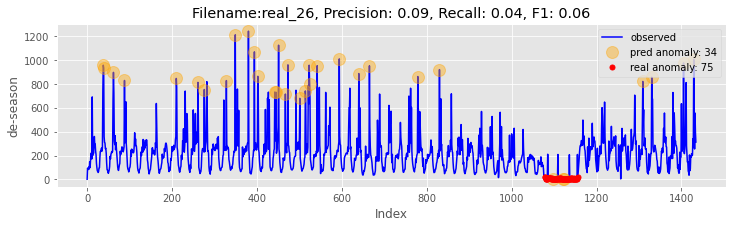

In [487]:
std = np.std(y[value])
mu = np.mean(y[value])
threshold_l = mu - how_many_std * std
threshold_r = mu + how_many_std * std

y_anomaly_pos = y[(y[value] <= threshold_l) | (y[value] >= threshold_r)]

y_pred = np.zeros(len(y))
y_pred[y_anomaly_pos['value'].index] = 1

y_test = np.zeros(len(y))
y_test[anomaly_idx] = 1

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
recall = recall_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred)


# Plot
fig, ax = plt.subplots(1, figsize=(12, 3))
ax.plot(y['value'], label='observed', color="blue")
# ax.plot(pred.predicted_mean, label='One-step ahead Forecast', alpha=.5)
plt.plot(y_anomaly_pos['value'], 'ro', color="orange", alpha = 0.4, ms = 12, label='pred anomaly: ' + str(len(y_anomaly_pos.index)))
plt.plot(y.loc[anomaly_idx]['value'], 'ro', color="red", ms = 5, label='real anomaly: ' + str(len(anomaly_idx)))


plt.title('Filename:' + filename 
          + ', Precision: {:.2f}'.format(precision) 
          + ', Recall: {:.2f}'.format(recall)
          + ', F1: {:.2f}'.format(f1))


ax.set_xlabel('Index')
ax.set_ylabel(value)
plt.legend()
plt.show()

### Using Box-Cox Tranform

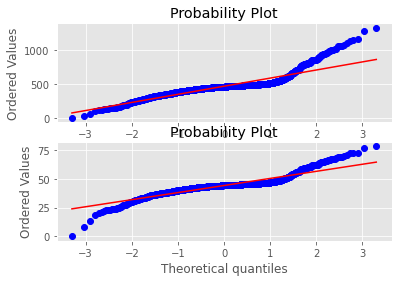

In [488]:
value_positive = y[value] - min(y[value]) + 1
value_tranform, _ = stats.boxcox(value_positive)
y['value_tranform']  = value_tranform

fig = plt.figure()
ax1 = fig.add_subplot(211)
prob = stats.probplot(value_positive, dist=stats.norm, plot=ax1)
# sns.histplot(gap, kde=True)

ax2 = fig.add_subplot(212)
prob = stats.probplot(value_tranform, dist=stats.norm, plot=ax2)

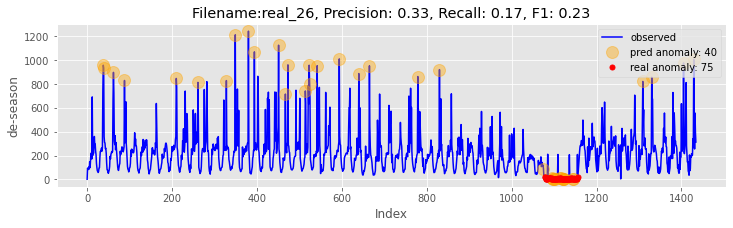

In [489]:
std = np.std(y['value_tranform'])
mu = np.mean(y['value_tranform'])
threshold_l = mu - how_many_std * std
threshold_r = mu + how_many_std * std

y_anomaly_pos = y[(y['value_tranform'] <= threshold_l) | (y['value_tranform'] >= threshold_r)]

y_pred = np.zeros(len(y))
y_pred[y_anomaly_pos['value'].index] = 1

y_test = np.zeros(len(y))
y_test[anomaly_idx] = 1

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
recall = recall_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred)


# Plot
fig, ax = plt.subplots(1, figsize=(12, 3))
ax.plot(y['value'], label='observed', color="blue")
# ax.plot(pred.predicted_mean, label='One-step ahead Forecast', alpha=.5)
plt.plot(y_anomaly_pos['value'], 'ro', color="orange", alpha = 0.4, ms = 12, label='pred anomaly: ' + str(len(y_anomaly_pos.index)))
plt.plot(y.loc[anomaly_idx]['value'], 'ro', color="red", ms = 5, label='real anomaly: ' + str(len(anomaly_idx)))

plt.title('Filename:' + filename 
          + ', Precision: {:.2f}'.format(precision) 
          + ', Recall: {:.2f}'.format(recall)
          + ', F1: {:.2f}'.format(f1))


ax.set_xlabel('Index')
ax.set_ylabel(value)
plt.legend()
plt.show()

## ARIMA

### Using Orignal

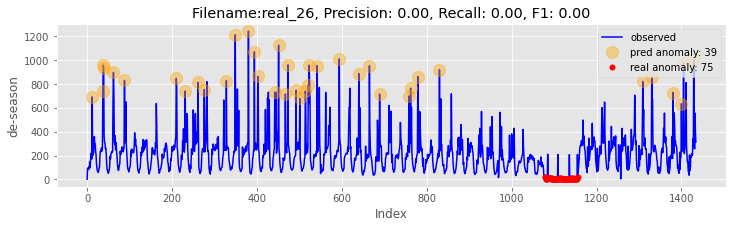

In [490]:
std_gap = np.std(gap)
mu_gap = np.mean(gap)
threshold_l_gap = mu_gap - how_many_std * std_gap
threshold_r_gap = mu_gap + how_many_std * std_gap

# IQR = gap.quantile(0.75) - gap.quantile(0.25)
# threshold_l_gap = gap.quantile(0.25) - 1.5*IQR
# threshold_r_gap = gap.quantile(0.75) + 1.5*IQR

y_anomaly_pos_arima = y[(y['gap'] <= threshold_l_gap) | (y['gap'] >= threshold_r_gap)]


y_pred = np.zeros(len(y))
y_pred[y_anomaly_pos_arima.index] = 1

y_test = np.zeros(len(y))
y_test[anomaly_idx] = 1

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
recall = recall_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred)


# Plot
fig, ax = plt.subplots(1, figsize=(12, 3))
ax.plot(y['value'], label='observed', color="blue")
# ax.plot(pred.predicted_mean, label='One-step ahead Forecast', alpha=.5)
plt.plot(y_anomaly_pos_arima['value'], 'ro', color="orange", alpha = 0.4, ms = 12, label='pred anomaly: ' + str(len(y_anomaly_pos_arima.index)))
plt.plot(y.loc[anomaly_idx]['value'], 'ro', color="red", ms = 5, label='real anomaly: ' + str(len(anomaly_idx)))

plt.title('Filename:' + filename 
          + ', Precision: {:.2f}'.format(precision) 
          + ', Recall: {:.2f}'.format(recall)
          + ', F1: {:.2f}'.format(f1))

ax.set_xlabel('Index')
ax.set_ylabel(value)
plt.legend()
plt.show()

### Using Box-CoxTransform

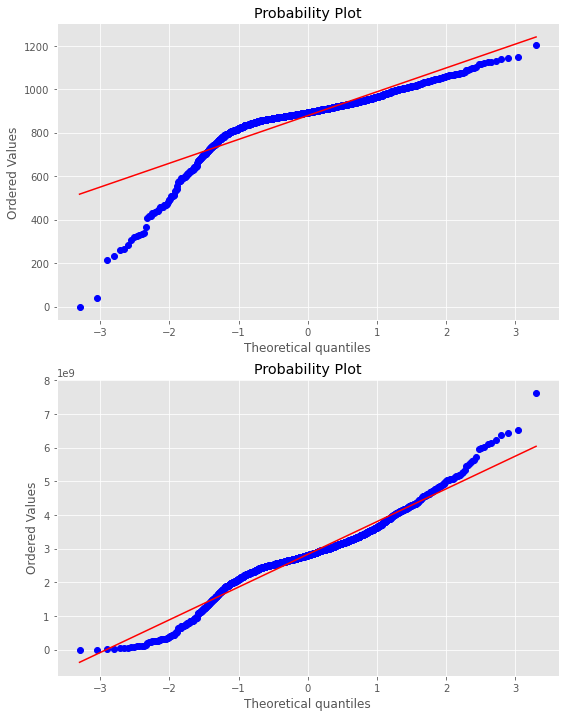

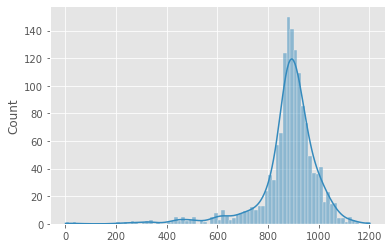

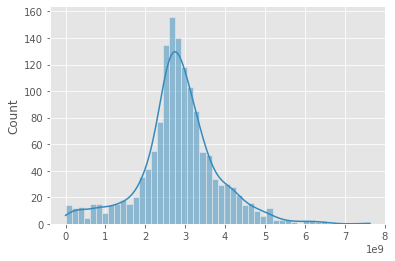

In [491]:
gap_positive = gap - min(gap) + 1
gap_tranform, _ = stats.boxcox(gap_positive)
y['gap_tranform']  = gap_tranform

fig = plt.figure(figsize = (9,12))
ax1 = fig.add_subplot(211)
prob = stats.probplot(gap_positive, dist=stats.norm, plot=ax1)

ax2 = fig.add_subplot(212)
prob = stats.probplot(gap_tranform, dist=stats.norm, plot=ax2)

plt.show()
sns.histplot(gap_positive, kde=True)
plt.show()
sns.histplot(gap_tranform, kde=True)
plt.show()

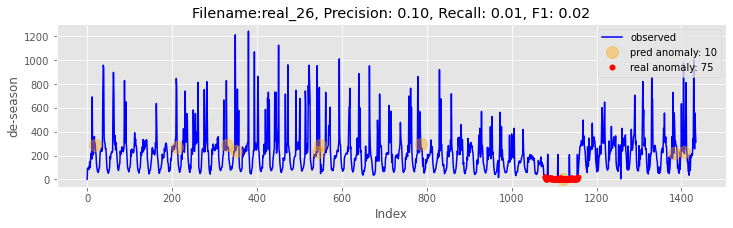

In [492]:
std_gap_transform = np.std(gap_tranform)
mu_gap_transform = np.mean(gap_tranform)
threshold_l_gap = mu_gap_transform - how_many_std * std_gap_transform
threshold_r_gap = mu_gap_transform + how_many_std * std_gap_transform

y_anomaly_pos_arima = y[(y['gap_tranform'] <= threshold_l_gap) | (y['gap_tranform'] >= threshold_r_gap)]


y_pred = np.zeros(len(y))
y_pred[y_anomaly_pos_arima.index] = 1

y_test = np.zeros(len(y))
y_test[anomaly_idx] = 1

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
recall = recall_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred)


# Plot
fig, ax = plt.subplots(1, figsize=(12, 3))
ax.plot(y['value'], label='observed', color="blue")
# ax.plot(pred.predicted_mean, label='One-step ahead Forecast', alpha=.5)
plt.plot(y_anomaly_pos_arima['value'], 'ro', color="orange", alpha = 0.4, ms = 12, label='pred anomaly: ' + str(len(y_anomaly_pos_arima.index)))
plt.plot(y.loc[anomaly_idx]['value'], 'ro', color="red", ms = 5, label='real anomaly: ' + str(len(anomaly_idx)))

plt.title('Filename:' + filename 
          + ', Precision: {:.2f}'.format(precision) 
          + ', Recall: {:.2f}'.format(recall)
          + ', F1: {:.2f}'.format(f1))

ax.set_xlabel('Index')
ax.set_ylabel(value)
plt.legend()
plt.show()